In [5]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mp
import sklearn
from IPython.display import Image

%matplotlib inline

# Naive Bayes and Support Vector Machines

Today we'll look at two more very commonly-used, widely applicable classification methods.

* Naive Bayes Classifier
* Support Vector Machine

## Naive Bayes

Let's start from the definition of conditional probability:

$$ P[A\,|\,C] = \frac{P[A \text{ and } C]}{P[C]} $$

So:

$$ P[A \text{ and } C] = P[A\,|\,C] \cdot P[C]. $$

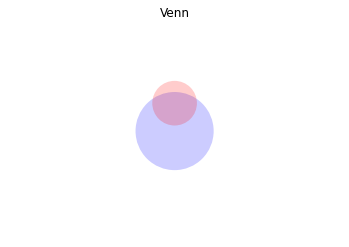

In [21]:
plt.figure()
ax=plt.gcf().gca()
circle = mp.patches.Circle([1, 1], 0.7, facecolor = 'blue', alpha = 0.2)
ax.add_artist(circle)
circle = mp.patches.Circle([1, 1.5], 0.4, facecolor = 'red', alpha = 0.2)
ax.add_artist(circle)
ax.axis('equal')
ax.axis('off')
plt.xlim([-2, 4])
plt.ylim([-2, 4])
plt.title('Venn');

Switching the roles of $A$ and $C$, we can equally say:

$$ P[C \text{ and } A] = P[C\,|\,A] \cdot P[A]. $$

Now $P[C \text{ and } A] = P[A \text{ and } C]$, so:
    
$$ P[A\,|\,C] \cdot P[C] = P[C\,|\,A] \cdot P[A] $$

Rearranging, we get __Bayes' Rule__:
    
$$ P[A\,|\,C] = \frac{P[C\,|\,A] \cdot P[A]}{P[C]}. $$

So there is nothing "magic" about Bayes' Rule: it simply follows from the basic laws of probability.

However, it is __very__ useful!

The reason is that often, $P[A\,|\,C]$ is not known, but the expressions on the right are known.

(We've already seen how this is used in the EM algorithm for Gaussian Mixture Modeling.)

### Using Bayes Rule in a Classifier

Let's start with a simple example:
   * A doctor knows that meningitis causes a stiff neck 75% of the time.
   * This is $P[S\,|\,M]$. 
   
A patient presents with a stiff neck.  What is the probability she has meningitis?

Well, we can't say.  What we know is $P[S\,|\,M]$, but what we want to know is $P[M\,|\,S]$!

Now perhaps the doctor knows that 
   * 1 in 20 people in the population have a stiff neck at any given time
       * $P[S] = 1/20$
   * 1 in 10,000 people in the population have meningitis at any given time
       * $P[M] = 1/10000$

   
Now, we can calculate the answer needed:

$$ P[M\,|\,S] = \frac{P[S\,|\,M]}{P[S]}\cdot P[M] = \frac{3/4}{1/20} \cdot 1/10000 = \fbox{$15 \cdot 1/10000$} = 0.0015. $$

I wrote the expressions above that way to point out the essence of Bayesian reasoning:
* A random person has probability 1/10000 of having meningitis
* When __we learn__ that the person has a stiff neck, it __increases their probability__ by a factor of 15.



We are going to use this same principle to construct a classifier.

Given a set of items with features and class labels,

the __class label__ will play the role of "meningitis" and the various __attributes__ of the item will play the role of "stiff neck."

We will then ask "how does the value of each feature change the probability of the class label?"

More formally:
    
Consider an item $\mathbf{x}$ having attributes $x_1, x_2, \dots, x_n$.

There are various classes (labels) for items: $C_1, \dots, C_k$.

Our goal is to predict the class of $\mathbf{x}$.

To do that, we will compute $P[C_1\,|\,\mathbf{x}], P[C_2\,|\,\mathbf{x}], \dots, P[C_k\,|\,\mathbf{x}]$.

These form a __soft classification__ of $\mathbf{x}$.

From them, we can form a hard classification.  One way would simply be to choose the class with highest probability.

This is the MAP (Maximum A Posteriori) Estimate: 

$$\hat{C} = \arg\max_{\{C_i\}} P[C_i\,|\,\mathbf{x}].$$

Now $P[C_i\,|\,\mathbf{x}] = P[C_i\,|\,x_1, x_2, \dots, x_n]$

How can we approach this problem?

The __key idea__ is that Bayes Rule makes clear that 

$$ P[C_i\,|\,\mathbf{x}] = \frac{P[\mathbf{x}\,|\,C_i]}{P[\mathbf{x}]} \cdot P[C_i] $$

Now, when we vary $C_i$ in the above expression, $P[\mathbf{x}]$ is not changing.

So ... 

The $\hat{C}$ that maximizes $P[C_i\,|\,x_1, x_2, \dots, x_n]$ is the __same__ as the $\hat{C}$ that maximizes $P[x_1, x_2, \dots, x_n\,|\,C_i]\cdot P[C_i]$.

This gives us an angle of attack on the problem.

The difficult problem that remains is how to estimate

$$ P[x_1, x_2, \dots, x_n\,|\,C_i]. $$

To see the challenge, imagine if we tried to compute this directly from data. 

Attacking head-on, we could use a histogram to estimate the necessary distribution.  In other words, simply count up how many times we see each combination of feature values.

Let's say there are 10 possible values for each feature, and there are 20 features. 

Then for each class $C_i$ we need to construct a histogram with $10^{20}$ bins!   

We would never expect to have enough data to fill all those bins.

The central problem we face is the high dimensionality of the feature space.

So, we need to find a way to reduce the exponential size of the estimation problem.

We will do that by __factoring__ the distribution $P[x_1, x_2, \dots, x_n\,|\,C_i]$.

Here is where the "Naive" part comes in.

We will __assume__ that __attributes are independent__ in their assignment to items.

This is indeed a "naive" assumption ... but it can be surprisingly effective in practice.

That implies that:
    
$$ P[x_1, x_2, \dots, x_n\,|\,C_i] = P[x_1\,|\,C_i] \cdot P[x_2\,|\,C_i] \cdot \dots P[x_n\,|\,C_i]  $$

The factors $P[x_j\,|\,C_i]$ are individually much lower-dimensional than the full distribution.

In a naive Bayes model, the quantity we calculate for each class $C_i$ is

$$ P[x_1\,|\,C_i] \cdot P[x_2\,|\,C_i] \cdot \dots P[x_n\,|\,C_i] \cdot P[C_i] $$

You can see each conditional probability as a "correction factor" to $P[C_i]$.

Each factor $P[x_j\,|\,C_i]$ tells us how we should update our confidence in $C_i$ based on the value of a particular feature $x_j$.

So, what remains then is to estimate $P[x_j\,|\,C_i]$ for all $x_j$ and $C_i$.

We will estimate these quantities from our training data.

To summarize the steps of Naive Bayes:

__Training__

* Compute all the per-class attribute probabilities $P[x_j\,|\,C_i]$ from training data.
* Compute all the class probabilities $P[C_i]$ from the training data.

__Predicting__

* For a given item $\mathbf{x} = (x_1, x_2, \dots, x_n)$, 
    * For each class $C_i,$ compute $P[x_1\,|\,C_i] \cdot P[x_2\,|\,C_i] \cdot \dots P[x_n\,|\,C_i] \cdot P[C_i]$
    * For a hard classification, return the class that maximizes the above expression.

### Computing Attribute Probabilities from Data

In [ ]:
__Look at book for these.__

## Support Vector Machines

Murphy 2012 has a kind of nice description / motivation of SVMs.

# SVM and Naive Bayes in Python

## Support Vector Machines 

Working with the wine dataset available here:

https://archive.ics.uci.edu/ml/datasets/Wine

In [3]:
wine = pd.read_table("data/wine.data", sep=',')

attributes = ['region',
'Alcohol',
            'Malic acid',
            'Ash',
            'Alcalinity of ash',
            'Magnesium',
            'Total phenols',
            'Flavanoids',
            'Nonflavanoid phenols',
            'Proanthocyanins',
            'Color intensity',
            'Hue',
            'OD280/OD315 of diluted wines',
            'Proline']



wine.columns = attributes
# take 2 attributes and use a two dimensional training dataset
X = wine[['Alcohol', 'Malic acid',]].values
#            'Ash',
#            'Alcalinity of ash',
#            'Magnesium',
#            'Total phenols',
#            'Flavanoids', 'Nonflavanoid phenols','Proanthocyanins','Color intensity',  'Hue', 'OD280/OD315 of diluted wines', 'Proline']].values
grape = wine.pop('region')
y = grape.values
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 13 columns):
Alcohol                         177 non-null float64
Malic acid                      177 non-null float64
Ash                             177 non-null float64
Alcalinity of ash               177 non-null float64
Magnesium                       177 non-null int64
Total phenols                   177 non-null float64
Flavanoids                      177 non-null float64
Nonflavanoid phenols            177 non-null float64
Proanthocyanins                 177 non-null float64
Color intensity                 177 non-null float64
Hue                             177 non-null float64
OD280/OD315 of diluted wines    177 non-null float64
Proline                         177 non-null int64
dtypes: float64(11), int64(2)
memory usage: 18.1 KB


In [4]:
wine.head()
print(X.shape)

X, y = utils.shuffle(X, y, random_state=1)
print(X.shape)
print(y.shape)
print(y)

train_set_size = 100
X_train = X[:train_set_size]  # selects first 100 rows (examples) for train set
y_train = y[:train_set_size]
X_test = X[train_set_size:]   # selects from row 100 until the last one for test set
y_test = y[train_set_size:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(177, 2)
(177, 2)
(177,)
[2 2 1 2 1 3 2 1 2 2 1 1 2 1 2 2 3 1 2 1 1 2 3 2 1 2 1 1 1 2 3 3 3 1 2 2 2
 3 2 1 1 2 2 1 1 1 2 1 1 2 2 2 3 1 2 2 1 2 3 2 2 1 3 3 2 1 2 1 2 1 3 3 3 3
 2 1 3 1 2 3 1 2 1 3 2 2 1 2 2 3 1 2 2 2 3 2 2 2 3 1 1 1 3 1 2 3 3 1 2 1 2
 2 1 3 2 3 3 3 2 2 2 3 3 2 1 2 1 3 2 2 1 1 2 1 1 1 3 1 3 3 1 2 2 3 1 2 2 1
 1 1 2 2 1 3 3 2 2 2 1 3 3 3 3 3 2 1 1 3 2 3 3 2 3 3 2 3 1]
(100, 2) (100,)
(77, 2) (77,)


##### Using the SVM library of scikit-learn:  http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [5]:
svc = svm.SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred_test = svc.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_test))

Accuracy of SVM test set: 0.714285714286


Evaluating the fit of the classifier graphically

In [6]:
from matplotlib.colors import ListedColormap
# Create color maps for 3-class classification problem, as with iris
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_estimator(estimator, X, y):
    
    try:
        X, y = X.values, y.values
    except AttributeError:
        pass
    
    estimator.fit(X, y)
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.axis('tight')
    plt.axis('off')
    plt.tight_layout()

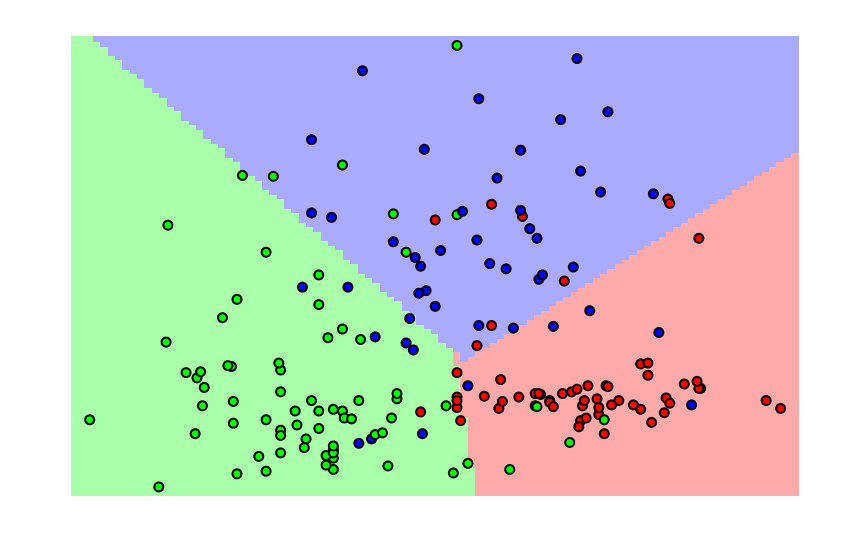

In [7]:
plot_estimator(svc, X, y)

The SVM gets its name from the samples in the dataset from each class that lie closest to the other class. These training samples are called "support vectors" because changing their position in p-dimensional space would change the location of the decision boundary.

In `scikit-learn`, the indices of the support vectors for each class can be found in the `support_vectors_` attribute of the SVC object. 

Here is a 2 class problem using only classes 1 and 2 in the wine dataset.

The support vectors are circled.

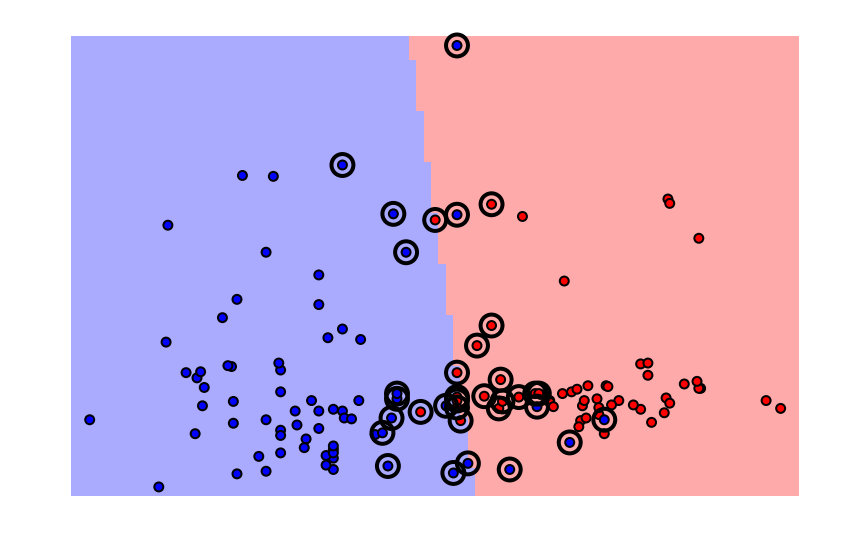

In [8]:
# Extract classes 1 and 2
X, y = X[np.in1d(y, [1, 2])], y[np.in1d(y, [1, 2])]

plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], 
           svc.support_vectors_[:, 1], 
           s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)

## Regularization

These two classes do not appear to be linearly separable.

For non-linearly separable classes we turn to __regularization.__

Regularization is tuned via the C parameter. 

In practice, a large C value means that the number of support vectors is small (less regularization, more model complexity), while a small C implies many support vectors (more regularization, less model complexity). 

`scikit-learn` sets a default value of C=1.

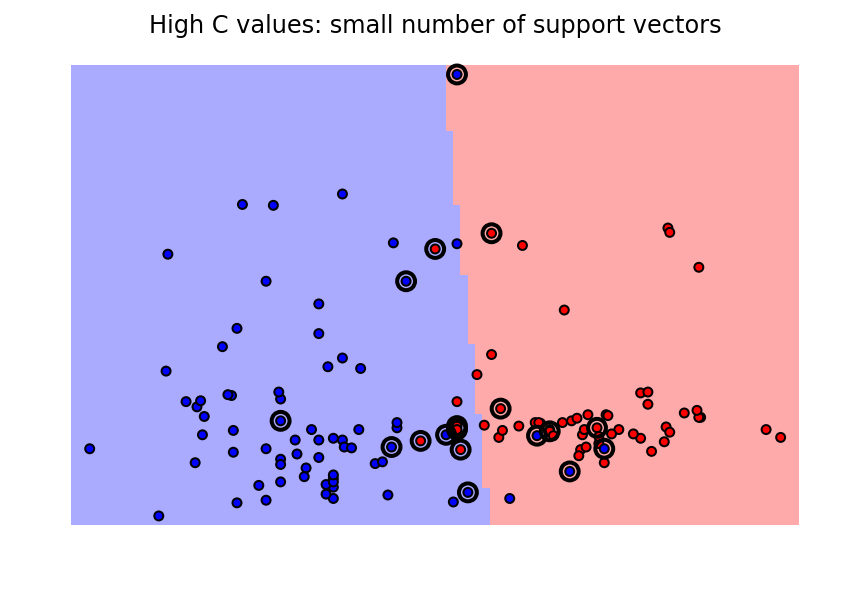

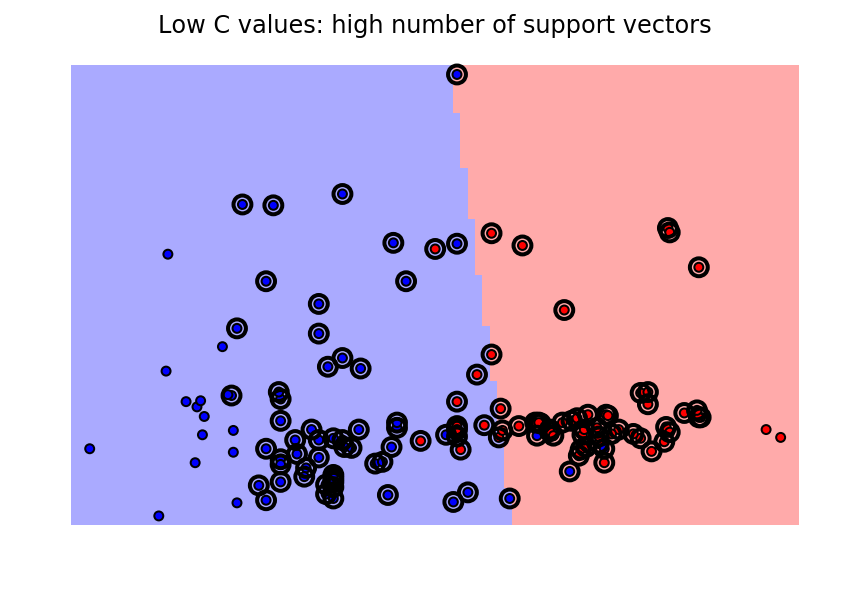

In [9]:
svc = svm.SVC(kernel='linear', C=1e6)
plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, 
            facecolors='none', linewidths=2, zorder=10)
plt.title('High C values: small number of support vectors')

svc = svm.SVC(kernel='linear', C=1e-2)
plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, 
            facecolors='none', linewidths=2, zorder=10)
plt.title('Low C values: high number of support vectors')

## Kernels

We can also choose from a suite of available kernels:

* linear, 
* poly, 
* rbf, 
* sigmoid, or 
* precomputed.

Or, a custom kernel can be passed as a function. 

Note that the radial basis function (rbf) kernel is just a Gaussian kernel, but with parameter $\gamma = \frac{1}{\sigma^2}$.

__Linear Kernel__

Accuracy of SVM test set: 0.922077922078


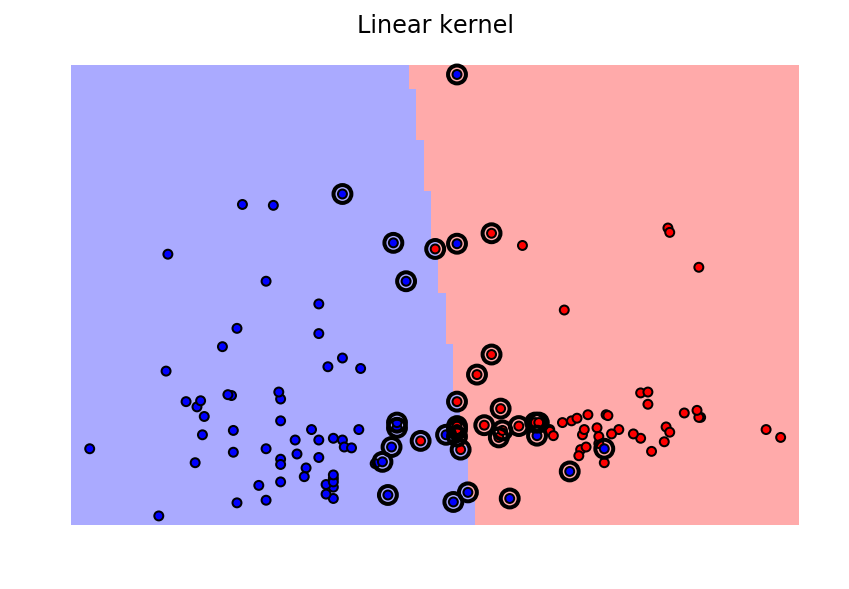

In [10]:
svc_lin = svm.SVC(kernel='linear')
plot_estimator(svc_lin, X, y)
plt.scatter(svc_lin.support_vectors_[:, 0], svc_lin.support_vectors_[:, 1], 
            s=80, facecolors='none', linewidths=2, zorder=10)
plt.title('Linear kernel')
y_pred_test = svc_lin.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_pred_test))

__Polynomial Kernel__

Accuracy of SVM test set: 0.831168831169


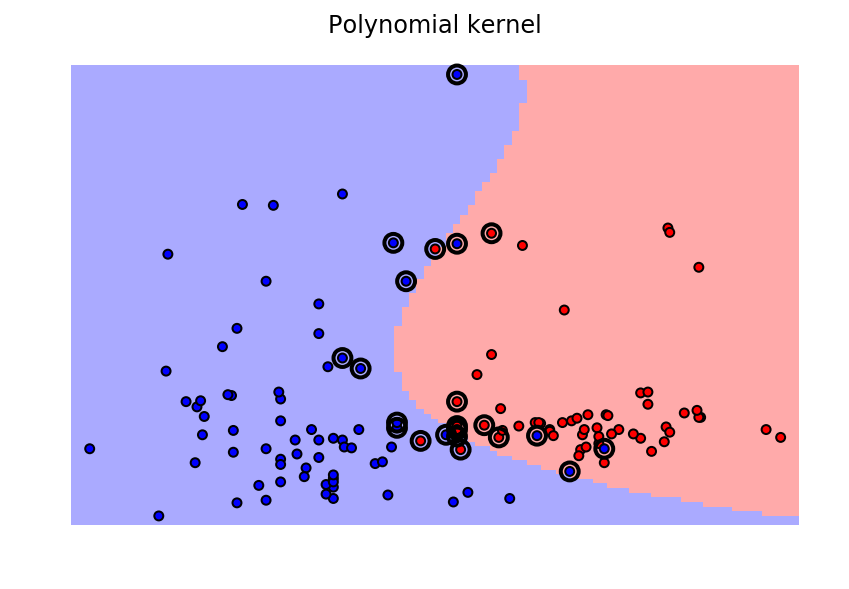

In [11]:
svc_poly = svm.SVC(kernel='poly', degree=3)
plot_estimator(svc_poly, X, y)
plt.scatter(svc_poly.support_vectors_[:, 0], svc_poly.support_vectors_[:, 1], 
           s=80, facecolors='none', linewidths=2, zorder=10)
plt.title('Polynomial kernel')
y_pred_test = svc_poly.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_pred_test))

__RBF kernel__

Accuracy of SVM test set: 0.987012987013


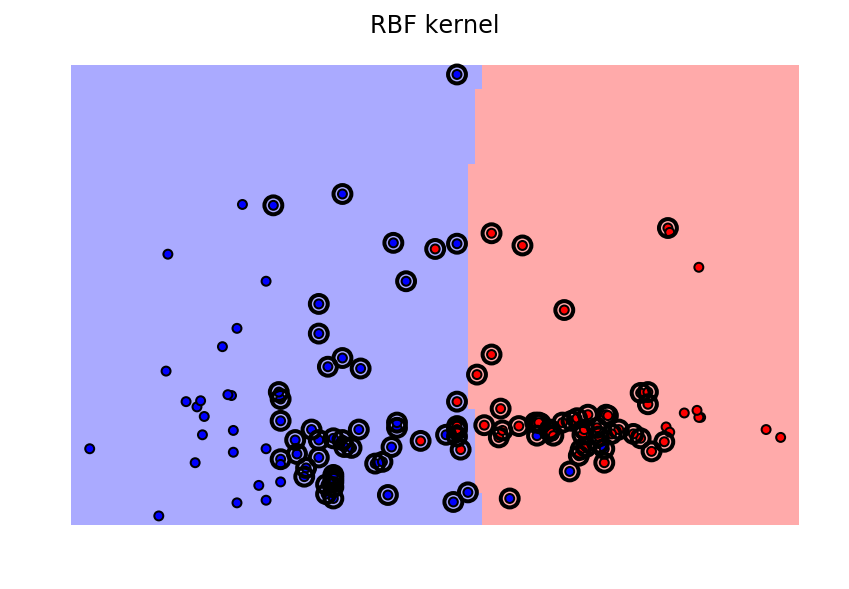

In [12]:
svc_rbf = svm.SVC(kernel='rbf', gamma=1e-2)
plot_estimator(svc_rbf, X, y)
plt.scatter(svc_rbf.support_vectors_[:, 0], svc_rbf.support_vectors_[:, 1], 
           s=80, facecolors='none', linewidths=2, zorder=10)
plt.title('RBF kernel')
y_pred_test = svc_rbf.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_pred_test))

## Cross-Validation

So far we've been evaluating our classifiers by 'holding out' test data.  

There is a problem with this, however: if we use the test data over and over, while varying model parameters, there is a new danger of overfitting.

The best way around this is to not use a fixed set of test data, but to sample the test data multiple times and look at the average behavior of the classifier.

In [13]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        wine.values, grape.values, test_size=0.4, random_state=0)

In [14]:
f = svm.SVC(kernel='linear', C=1)
f.fit(X_train, y_train)
f.score(X_test, y_test)

0.95774647887323938

So far, this is fine -- but what if we want to vary C?  Now, we are in danger of overfitting if we use the same test data to find the 'best' value of C.

In [15]:
#mean accuracy
scores = cross_validation.cross_val_score(f, wine.values, grape.values, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.86486486  0.97222222  0.94444444  1.          1.        ]
Accuracy: 0.96 (+/- 0.10)


## Analyzing the iris dataset

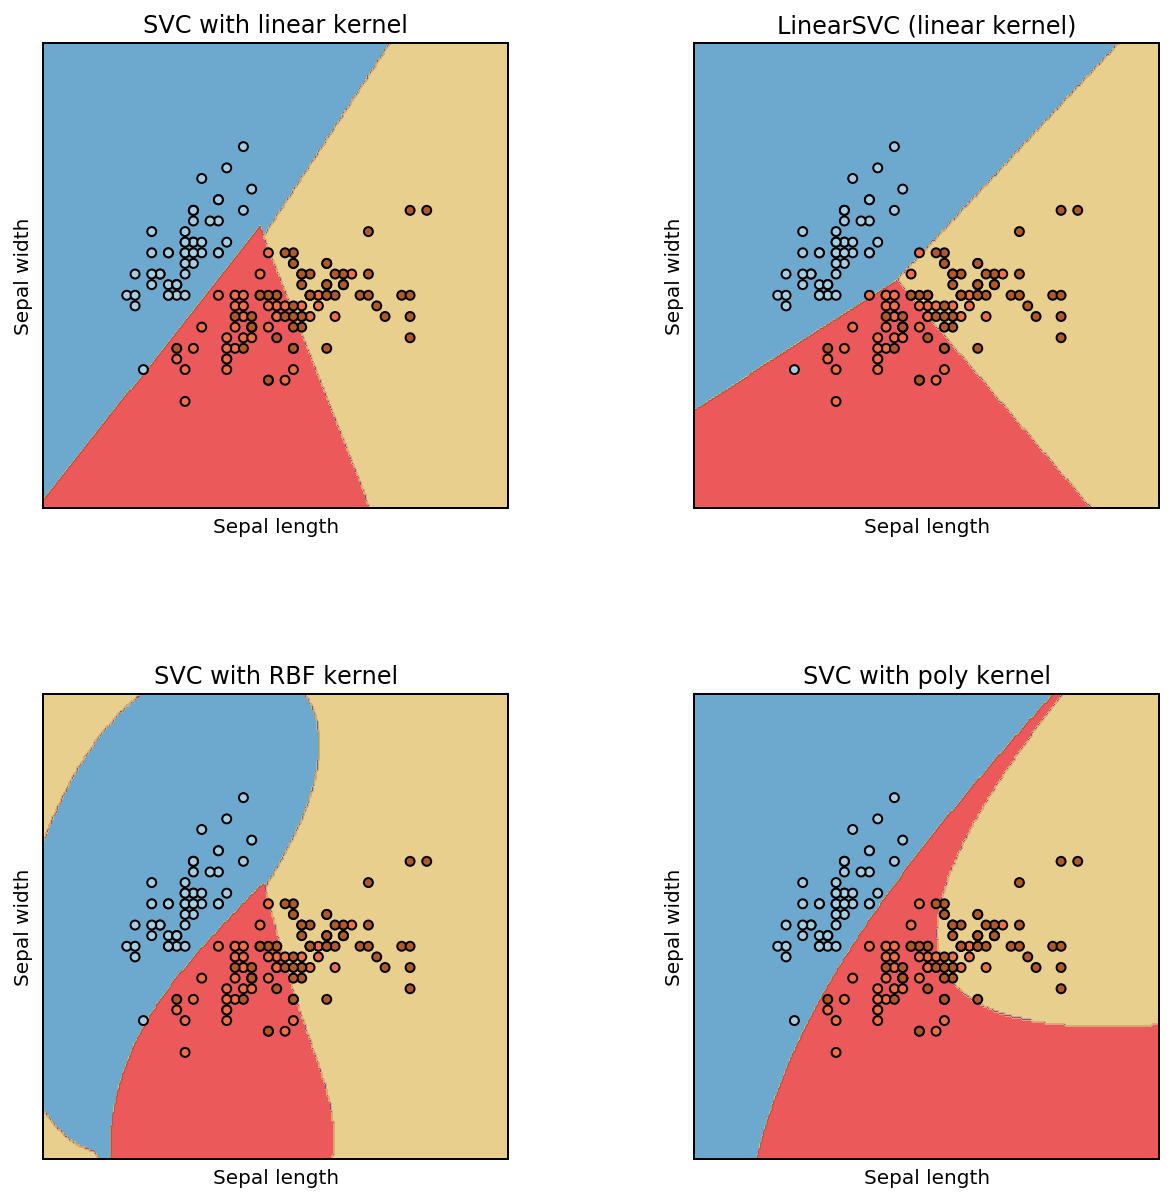

In [16]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel', 'SVC with poly kernel']

fig = plt.figure(figsize=(10,10))

for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

## Naive Bayes

To use Naive Bayes "out of the box", one has to treat all the features as either:
* Gaussian
* Multinomial (Categorical)
* Binary

`scikit-learn` provides a Naive Bayes classifier for each of these cases.

We'll use the Gaussian:

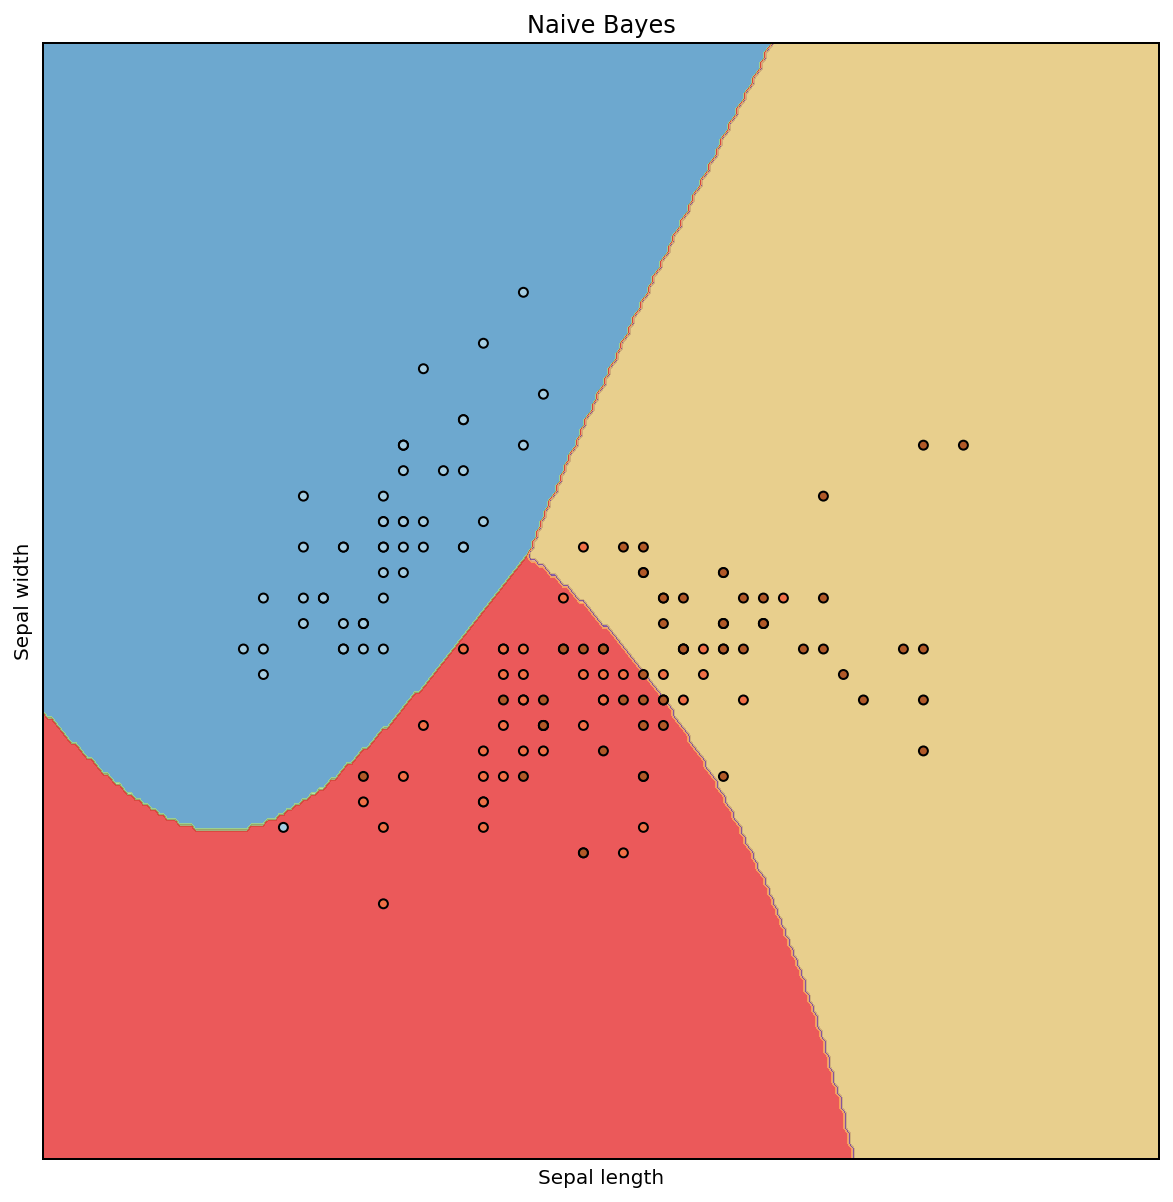

In [17]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

y_pred = gnb.fit(X, y).predict(X)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

fig = plt.figure(figsize=(10,10))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].

Z = gnb.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Naive Bayes')

plt.show()

In [1]:

import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.svm as svm
import sklearn.cross_validation as cross_validation
import sklearn.cluster as cluster
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from patsy import dmatrices

import seaborn as sns



/Users/markcrovella/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
